Initial data shape: (5952, 9)
Missing values:
 Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64
After datetime parsing, data shape: (5760, 13)

Traffic Situation distribution:
 Traffic Situation
normal    3491
heavy     1103
low        806
high       360
Name: count, dtype: int64


<ipython-input-15-3048093235>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = data['datetime'].dt.hour
<ipython-input-15-3048093235>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['datetime'].dt.day
<ipython-input-15-3048093235>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

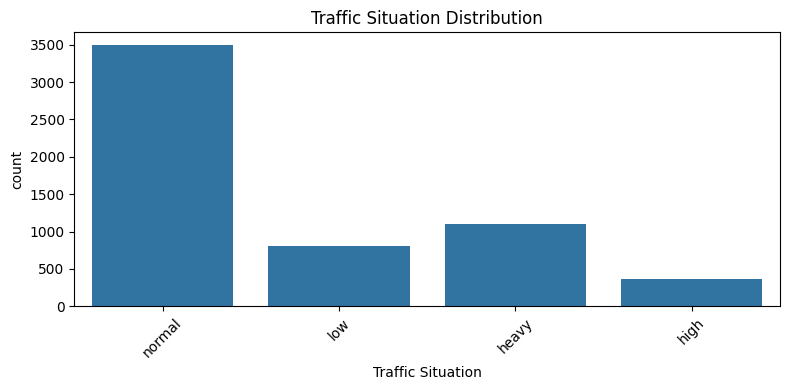


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9954
Weighted F1 Score: 0.9954

Classification Report:
               precision    recall  f1-score   support

       heavy       0.99      1.00      1.00       311
        high       0.99      0.99      0.99       120
         low       1.00      0.99      0.99       227
      normal       1.00      1.00      1.00      1070

    accuracy                           1.00      1728
   macro avg       0.99      0.99      0.99      1728
weighted avg       1.00      1.00      1.00      1728



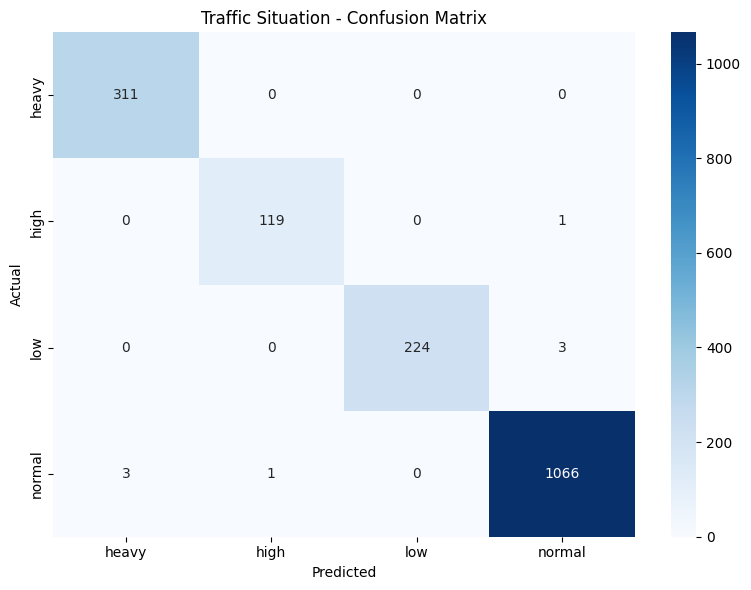

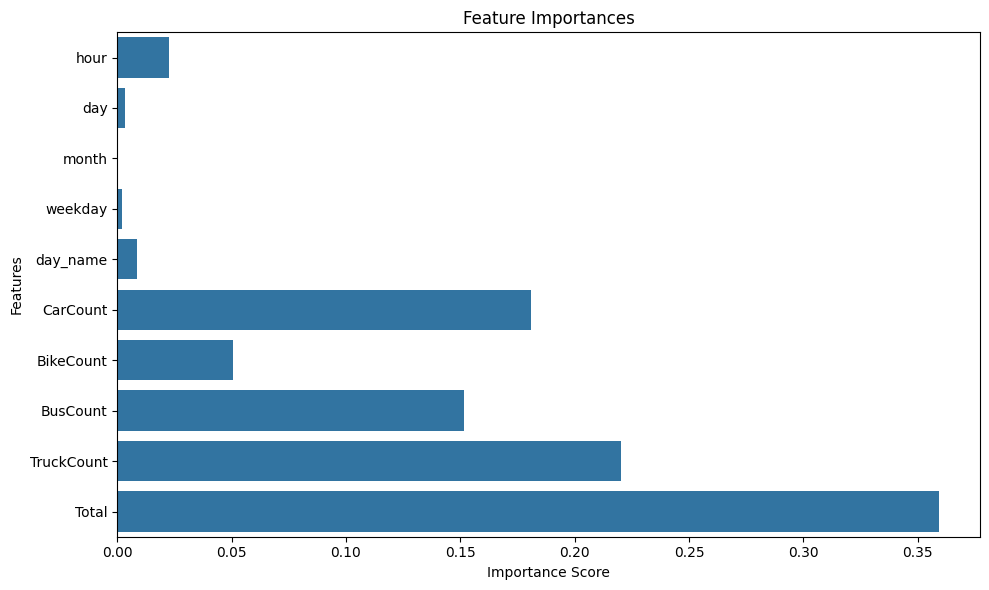


Sample Inference - Predicted Traffic Situation: low


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('/content/TrafficTwoMonth.csv')

# Basic sanity check
print("Initial data shape:", data.shape)
print("Missing values:\n", data.isnull().sum())

# Combine date and time properly
data['Day'] = data['Date'].astype(str).str.zfill(2)
data['Full_Date'] = '2024-06-' + data['Day']  # Assuming June 2024
data['datetime_str'] = data['Full_Date'] + ' ' + data['Time'].astype(str)

# Parse datetime
data['datetime'] = pd.to_datetime(
    data['datetime_str'],
    format='%Y-%m-%d %I:%M:%S %p',
    errors='coerce'
)

# Drop invalid datetimes
data = data.dropna(subset=['datetime'])
print("After datetime parsing, data shape:", data.shape)

# Extract datetime features
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.dayofweek

# Encode categorical variables
label_days = LabelEncoder()
data['day_name'] = label_days.fit_transform(data['Day of the week'])

label_situation = LabelEncoder()
data['Traffic_ID'] = label_situation.fit_transform(data['Traffic Situation'])

# Check class distribution
print("\nTraffic Situation distribution:\n", data['Traffic Situation'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='Traffic Situation', data=data)
plt.title('Traffic Situation Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Define features and target
features = ['hour', 'day', 'month', 'weekday', 'day_name',
            'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
X = data[features]
y = data['Traffic_ID']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search CV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Save the model
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Evaluation
y_pred = best_model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_situation.classes_)
conf_matrix = confusion_matrix(y_val, y_pred)

# Display results
print(f"\nBest Parameters: {grid.best_params_}")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_situation.classes_,
            yticklabels=label_situation.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Traffic Situation - Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance plot
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Sample inference
sample = X_val.iloc[[0]]
sample_pred = best_model.predict(sample)
predicted_label = label_situation.inverse_transform(sample_pred)
print(f"\nSample Inference - Predicted Traffic Situation: {predicted_label[0]}")







Balanced Synthetic Data Evaluation:
Accuracy: 0.3040
F1 Score (weighted): 0.2083
Classification Report:
               precision    recall  f1-score   support

       heavy       0.31      1.00      0.48       125
        high       0.00      0.00      0.00       125
         low       1.00      0.22      0.36       125
      normal       0.00      0.00      0.00       125

    accuracy                           0.30       500
   macro avg       0.33      0.30      0.21       500
weighted avg       0.33      0.30      0.21       500



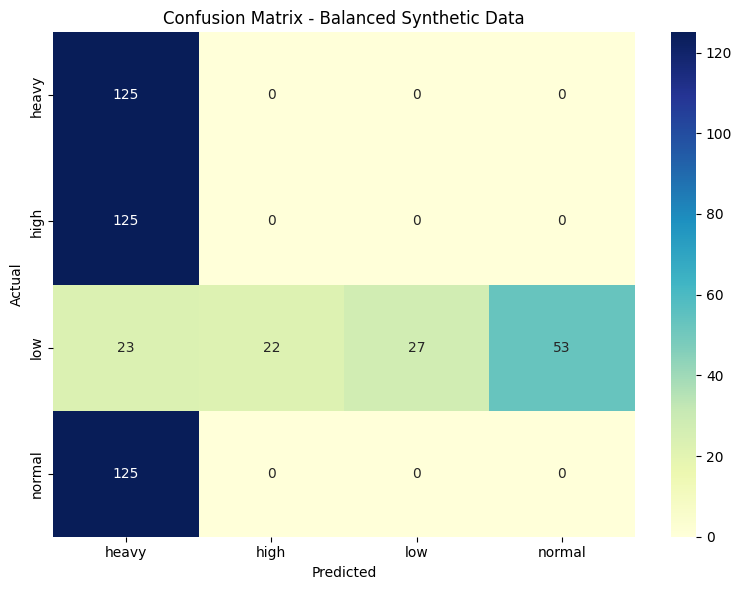


Sample Balanced Synthetic Predictions:
   CarCount  BikeCount  BusCount  TruckCount  Total Actual_Traffic_Situation  \
0        28         47        12          35    122                      low   
1        95         64        16          18    193                      low   
2        44         97        19          11    171                      low   
3        41         29         2          59    131                      low   
4        20         89        16          59    184                      low   
5        12         27        13          18     70                      low   
6        49        105        12           0    166                      low   
7        22         23        17          25     87                      low   
8        34         96        16          19    165                      low   
9        23         34        15           0     72                      low   

  Predicted_Traffic_Situation  
0                      normal  
1              

In [24]:
synthetic_balanced = []

# Define ranges for each class based on Total
class_ranges = {
    'low': (50, 199),
    'normal': (200, 299),
    'high': (300, 399),
    'heavy': (400, 400)
}

samples_per_class = 125

for cls, (min_total, max_total) in class_ranges.items():
    for _ in range(samples_per_class):
        # Randomly generate Total in target range
        total = np.random.randint(min_total, max_total + 1)

        # Randomly distribute total among vehicle types
        car = np.random.randint(10, total // 2)
        bike = np.random.randint(10, total - car)
        bus = np.random.randint(1, 20)
        truck = total - (car + bike + bus)
        if truck < 0: truck = 0  # ensure non-negative

        synthetic_balanced.append({
            'hour': np.random.randint(0, 24),
            'day': np.random.randint(1, 31),
            'month': 6,
            'weekday': np.random.randint(0, 7),
            'day_name': np.random.randint(0, len(label_days.classes_)),
            'CarCount': car,
            'BikeCount': bike,
            'BusCount': bus,
            'TruckCount': truck,
            'Total': car + bike + bus + truck,
            'Actual_Traffic_Situation': cls
        })

synthetic_df = pd.DataFrame(synthetic_balanced)

# Predict with model
X_synthetic = synthetic_df[['hour', 'day', 'month', 'weekday', 'day_name',
                            'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']]
synthetic_df['Predicted_Traffic_ID'] = best_model.predict(X_synthetic)
synthetic_df['Predicted_Traffic_Situation'] = label_situation.inverse_transform(synthetic_df['Predicted_Traffic_ID'])

# Encode actual labels
synthetic_df['Actual_Traffic_ID'] = label_situation.transform(synthetic_df['Actual_Traffic_Situation'])

# Evaluation
actual_ids = synthetic_df['Actual_Traffic_ID']
predicted_ids = synthetic_df['Predicted_Traffic_ID']

from sklearn.metrics import classification_report, confusion_matrix

acc = accuracy_score(actual_ids, predicted_ids)
f1 = f1_score(actual_ids, predicted_ids, average='weighted')

present_class_ids = sorted(set(actual_ids) | set(predicted_ids))
present_class_names = label_situation.inverse_transform(present_class_ids)

report = classification_report(actual_ids, predicted_ids,
                               labels=present_class_ids,
                               target_names=present_class_names,
                               zero_division=0)

conf_matrix = confusion_matrix(actual_ids, predicted_ids)

# Output
print("\nBalanced Synthetic Data Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Balanced Synthetic Data")
plt.tight_layout()
plt.show()

# Preview
print("\nSample Balanced Synthetic Predictions:")
print(synthetic_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total',
                    'Actual_Traffic_Situation', 'Predicted_Traffic_Situation']].head(10))
